In [1]:
# defininig the layers for a VAE encoder

import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Using TensorFlow backend.
W0723 09:10:29.084246 140257669474048 deprecation_wrapper.py:118] From /home/joel/anaconda3/envs/tensorflow-gpu-new/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:58: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 09:10:29.085937 140257669474048 deprecation_wrapper.py:118] From /home/joel/anaconda3/envs/tensorflow-gpu-new/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:442: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 09:10:29.089772 140257669474048 deprecation_wrapper.py:118] From /home/joel/anaconda3/envs/tensorflow-gpu-new/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3543: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 09:10:29.144417 140257669474048 deprecation.py:506] From /home/joel/anaconda3/envs/tensorflow-gpu-new/lib/python3.5/site-packages/keras/backend/tensor

In [2]:
# generating latent space point using the parameters of the distribution assumed to have produced input_img

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

W0723 09:10:29.182534 140257669474048 deprecation_wrapper.py:118] From /home/joel/anaconda3/envs/tensorflow-gpu-new/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3520: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



In [3]:
# defininig the layers for a VAE decoder

# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [4]:
# defininig custom layer for dual loss

class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

W0723 09:10:47.859959 140257669474048 deprecation_wrapper.py:118] From /home/joel/anaconda3/envs/tensorflow-gpu-new/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2819: The name tf.log is deprecated. Please use tf.math.log instead.

W0723 09:10:47.868355 140257669474048 deprecation.py:323] From /home/joel/anaconda3/envs/tensorflow-gpu-new/lib/python3.5/site-packages/tensorflow_core/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# instantiating and training the model
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

/home/joel/anaconda3/envs/tensorflow-gpu-new/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 14, 14, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 14, 14, 64)    36928       conv2d_2[0][0]                   
___________________________________________________________________________________________

W0723 09:15:41.999729 140257669474048 deprecation.py:506] From /home/joel/anaconda3/envs/tensorflow-gpu-new/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:625: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 22s - loss: 73570154.5734 - val_loss: 0.2011
Epoch 2/10
60000/60000 [==============================] - 18s - loss: 0.1956 - val_loss: 0.1932
Epoch 3/10
60000/60000 [==============================] - 18s - loss: 0.1906 - val_loss: 0.1885
Epoch 4/10
60000/60000 [==============================] - 18s - loss: 0.1879 - val_loss: 0.1881
Epoch 5/10
60000/60000 [==============================] - 18s - loss: 0.1862 - val_loss: 0.1862
Epoch 6/10
60000/60000 [==============================] - 18s - loss: 0.1850 - val_loss: 0.1849
Epoch 7/10
60000/60000 [==============================] - 19s - loss: 0.1841 - val_loss: 0.1849
Epoch 8/10
60000/60000 [==============================] - 19s - loss: 0.1833 - val_loss: 0.1832
Epoch 9/10
60000/60000 [==============================] - 19s - loss: 0.1828 - val_loss: 0.1828
Epoch 10/10
60000/60000 [==============================] - 18s - loss: 0.1825 -

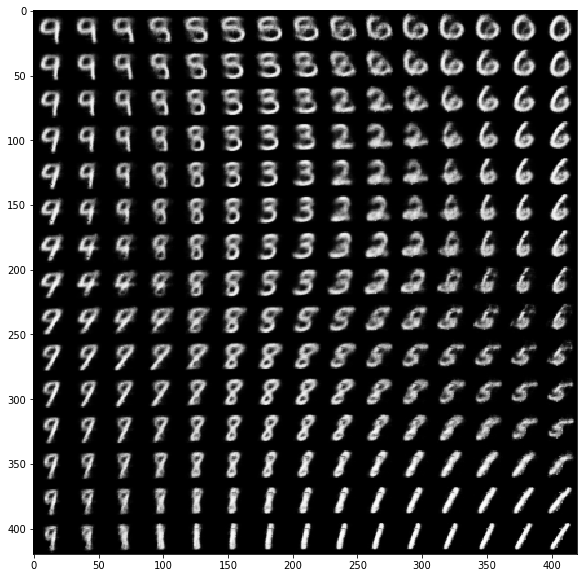

In [10]:
# sampling a grid of points from the 2D latent space and decoding them into images

import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()